# Tools

In [1]:
import numpy as np
import pandas as pd
import os
import re
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.layers import TextVectorization
from tensorflow import keras
from tensorflow.keras import Sequential, layers, models, regularizers
from keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional

# Dataset

In [2]:
!wget --no-check-certificate https://storage.googleapis.com/learning-datasets/sarcasm.json

--2025-02-08 14:58:34--  https://storage.googleapis.com/learning-datasets/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.207, 142.250.157.207, 142.251.8.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘sarcasm.json’

sarcasm.json        100%[===================>]   5.38M  4.61MB/s    in 1.2s    

2025-02-08 14:58:36 (4.61 MB/s) - ‘sarcasm.json’ saved [5643545/5643545]



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_json("sarcasm.json")

In [5]:
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [6]:
df.shape

(26709, 3)

In [7]:
sentences = df['headline'].to_list()
labels = df['is_sarcastic'].to_list()

# Clean the data


In [8]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = " ".join(filter(lambda x: x[0] != '@', text.split()))
    return text

## Pre-processing

In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
sw = stopwords.words('english')
print(sw)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [11]:
for i in range(len(sentences)):
  sentences[i] = clean_text(sentences[i])
  words = sentences[i].split()
  words_new = [w for w in words if w not in sw]
  sentences[i] = ' '.join(words_new)

# Train-test split

In [12]:
random.shuffle(sentences)

In [13]:
training_size = 18696
test_size = 5342
train_sentences = sentences[:training_size]
test_sentences = sentences[training_size:training_size + test_size]
validation_sentences = sentences[training_size + test_size:]

train_labels = labels[:training_size]
test_labels = labels[training_size:training_size + test_size]
validation_labels = labels[training_size + test_size:]

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)
validation_labels = np.array(validation_labels)

# Text-vectorization layer

In [14]:
max_words = 5000
maxlen = 100

In [15]:
text_vectorization = TextVectorization(
    max_tokens=max_words,
    output_mode='int',
    output_sequence_length=maxlen
)
text_vectorization.adapt(train_sentences)
print(len(text_vectorization.get_vocabulary()))

5000


In [16]:
train_sequences = text_vectorization(train_sentences)
test_sequences = text_vectorization(test_sentences)
validation_sequences = text_vectorization(validation_sentences)

print(type(train_sequences))
print(train_sequences.shape)
print(test_sequences.shape)
print(validation_sequences.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'>
(18696, 100)
(5342, 100)
(2671, 100)


# Load GloVe model

In [17]:

glove_dir = '/content/drive/MyDrive'
embeddings_index = {}
f = open(os.path.join(glove_dir,"glove.6B.100d.txt"))
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


# Build the embedding layer

In [18]:
embedding_dim = 100
vocabulary = text_vectorization.get_vocabulary()
word_index = {word: index for index, word in enumerate(vocabulary)}

In [19]:
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [20]:
embedding_layer = Embedding(max_words,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=False)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


# Model Design

In [21]:
model = Sequential([
    embedding_layer,
    layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
    layers.Bidirectional(layers.LSTM(64, dropout=0.3, recurrent_dropout=0.3)),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'),
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │         500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 500,000 (1.91 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 500,000 (1.91 MB)

In [22]:
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [23]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Training

In [ ]:
history = model.fit(train_sequences, train_labels, batch_size=128, epochs=50,
                    validation_data=(validation_sequences, validation_labels), callbacks=[early_stopping])

Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 331s 2s/step - accuracy: 0.5627 - loss: 0.6839 - val_accuracy: 0.5751 - val_loss: 0.6850
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 357s 2s/step - accuracy: 0.5560 - loss: 0.6855 - val_accuracy: 0.5751 - val_loss: 0.6843
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 308s 2s/step - accuracy: 0.5553 - loss: 0.6860 - val_accuracy: 0.5751 - val_loss: 0.6850
Epoch 4/50
 38/147 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - accuracy: 0.5746 - loss: 0.6826

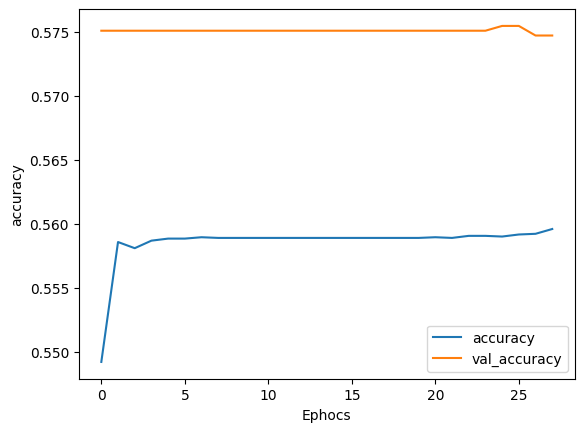

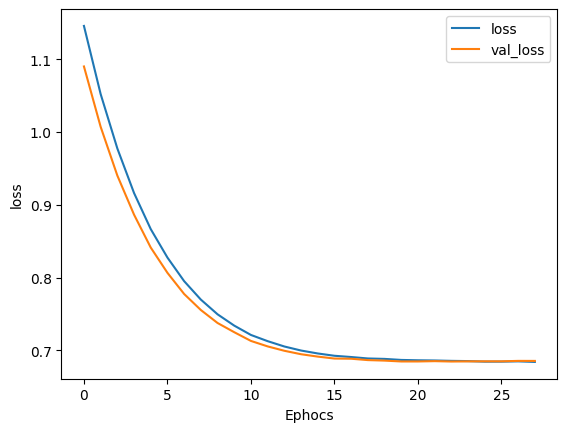

In [25]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history["val_" + string])
  plt.xlabel("Ephocs")
  plt.ylabel(string)
  plt.legend([string, "val_" + string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [26]:
test_loss, test_accuracy = model.evaluate(test_sequences, test_labels)
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Loss: {test_loss:.2f}")

167/167 ━━━━━━━━━━━━━━━━━━━━ 23s 136ms/step - accuracy: 0.5716 - loss: 0.6852
Test Accuracy: 0.56
Test Loss: 0.69


In [29]:
def predict_sarcasm(s):
    s = clean_text(s)
    words = s.split()
    words_new = [w for w in words if w not in sw]
    s = ' '.join(words_new)

    sequence = text_vectorization([s])
    pred = model.predict(sequence)
    pred *= 100
    if pred[0][0] >= 50:
        return "It's a sarcasm!"
    else:
        return "It's not a sarcasm."